# Data cleaning and pre-processing

Import des librairies et déclaration du chemin d'accès à la base de données

In [1]:
import pathlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

# J'ignore les avertissements (ceci était inutiles)
import warnings
warnings.filterwarnings("ignore")

dbPath = r"dataSources"
path = pathlib.Path(dbPath)

Transcodification du .npz en dataframe puis enregistrement du dataframe en .csv

In [2]:
arrays = dict(np.load(path / "transactions.npz"))
data = {k: [s.decode("utf-8") for s in v.tobytes().split(b"\x00")] if v.dtype == np.uint8 else v for k, v in arrays.items()}
df_transactions = pd.DataFrame.from_dict(data)

df_transactions.to_csv(r"dataSources\transactions.csv", header=True)

Lecture du .csv dans un dataframe que je clean en supprimant les colonnes inutiles.  
Puis création d'un colonne 'prix_m2' en divisant la colonne 'pix' par le colonne 'surface_habitable'

In [3]:
df_transactions = pd.read_csv(r'dataSources\transactions.csv')

if 'Unnamed: 0' in df_transactions.columns:
    df_transactions = df_transactions.drop('Unnamed: 0', axis=1)
    
df_transactions['prix_m2'] = df_transactions['prix'] / (df_transactions['surface_habitable'])

df_transactions.head()

,id_transaction,date_transaction,prix,departement,id_ville,ville,code_postal,adresse,type_batiment,vefa,...,surface_habitable,id_parcelle_cadastre,latitude,longitude,surface_dependances,surface_locaux_industriels,surface_terrains_agricoles,surface_terrains_sols,surface_terrains_nature,prix_m2
0,126289,2014-01-02,197000.0,1,427,TREVOUX,1600,6346 MTE DES LILAS,Appartement,False,...,84,01427000AD0575,45.942301,4.770694,"{0,0}",{},{},{},{},2345.238095
1,126606,2014-01-02,157500.0,1,451,VIRIAT,1440,1369 RTE DE STRASBOURG,Maison,False,...,103,01451000ZO0158,46.236407,5.262935,{},{},{},"{24,1569}",{},1529.126214
2,123875,2014-01-02,112000.0,1,365,SAINT-JEAN-SUR-VEYLE,1290,5174 SAINT JEAN SUR VEYLE,Maison,False,...,78,013650000C0813,46.260087,4.918587,{},{},{220},{540},{},1435.897436
3,130652,2014-01-02,173020.0,1,202,LAGNIEU,1150,21 GR GRANDE RUE DE BULLIEZ,Maison,False,...,72,012020000F1248,45.899056,5.354210,{},{},{},"{191,336}",{},2403.055556
4,132775,2014-01-03,49023.3,1,27,BALAN,1360,7 LOT AFU DE BARBAREL,Maison,False,...,105,010270000D1790,45.832127,5.097926,{},{},{},{1027},{},466.888571


Filtre du dataframe pour ne garder que les données de l'IDF dans un dataframe et que celles de Paris dans un autre.  
J'en profite pour supprimer les lignes de mes dataframes qui ont d'autres surfaces que celles habitables (les prix au m² de surfaces habitables sont différents d'autres surfaces).  
Je filtre les prix au m² supérieur à 20k€ pour l'IDF et pour Paris.  
Je filtre également les prix au m² inférieur à 3k€, seulement pour Paris.

In [4]:
df_idf = df_transactions[(df_transactions.departement.isin([75, 77, 78, 91, 92, 93, 94, 95])) &
                         (df_transactions.date_transaction.str.startswith('2022')) &
                         (df_transactions.type_batiment == 'Appartement') &
                         (df_transactions.prix_m2 < 20000)]

surface_cols = [c for c in df_idf.columns if 'surface_' in c and c != 'surface_habitable']

for c in surface_cols:
    df_idf[c + '_sum'] = df_idf[c].apply(lambda x: sum(eval(x)) if 'NULL' not in x else 0)

df_idf = df_idf[df_idf[[c + '_sum' for c in surface_cols]].sum(axis=1) == 0]

df_paris = df_idf[(df_idf.departement == 75) &
                  (df_idf.prix_m2 > 3000)]

display(df_idf, df_paris)

,id_transaction,date_transaction,prix,departement,id_ville,ville,code_postal,adresse,type_batiment,vefa,...,surface_locaux_industriels,surface_terrains_agricoles,surface_terrains_sols,surface_terrains_nature,prix_m2,surface_dependances_sum,surface_locaux_industriels_sum,surface_terrains_agricoles_sum,surface_terrains_sols_sum,surface_terrains_nature_sum
6043985,10040024,2022-01-03,329910.0,75,112,PARIS 12,75012,260 AV DAUMESNIL,Appartement,False,...,{},{},{},{},10997.000000,0,0,0,0,0
6043986,10035062,2022-01-03,302400.0,75,102,PARIS 02,75002,52 RUE GRENETA,Appartement,False,...,{},{},{},{},11630.769231,0,0,0,0,0
6043987,10036657,2022-01-03,665000.0,75,117,PARIS 17,75017,26 BD DES BATIGNOLLES,Appartement,False,...,{},{},{},{},11271.186441,0,0,0,0,0
6043988,10035700,2022-01-03,965000.0,75,105,PARIS 05,75005,31 RUE CENSIER,Appartement,False,...,{},{},{},{},15317.460317,0,0,0,0,0
6043989,10029380,2022-01-03,200000.0,75,110,PARIS 10,75010,37 RUE DE PARADIS,Appartement,False,...,{},{},{},{},10526.315789,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8228478,13363983,2022-12-30,195000.0,95,127,CERGY,95000,2 RUE HAUTE DU TERTRE,Appartement,False,...,{},{},{},{},2407.407407,0,0,0,0,0
8228482,13367769,2022-12-30,268000.0,95,149,CHAUMONTEL,95270,2 RUE DE L ORME,Appartement,False,...,{},{},{},{},3941.176471,0,0,0,0,0
8228484,13363140,2022-12-30,129500.0,95,252,FRANCONVILLE LA GARENNE,95130,2 RUE DES FOLLES ENTREPRISES,Appartement,False,...,{},{},{},{},2443.396226,0,0,0,0,0
8228486,13367058,2022-12-30,635000.0,95,428,MONTMORENCY,95160,1 RUE DES SABLONS,Appartement,False,...,{},{},{},{},6546.391753,0,0,0,0,0


,id_transaction,date_transaction,prix,departement,id_ville,ville,code_postal,adresse,type_batiment,vefa,...,surface_locaux_industriels,surface_terrains_agricoles,surface_terrains_sols,surface_terrains_nature,prix_m2,surface_dependances_sum,surface_locaux_industriels_sum,surface_terrains_agricoles_sum,surface_terrains_sols_sum,surface_terrains_nature_sum
6043985,10040024,2022-01-03,329910.0,75,112,PARIS 12,75012,260 AV DAUMESNIL,Appartement,False,...,{},{},{},{},10997.000000,0,0,0,0,0
6043986,10035062,2022-01-03,302400.0,75,102,PARIS 02,75002,52 RUE GRENETA,Appartement,False,...,{},{},{},{},11630.769231,0,0,0,0,0
6043987,10036657,2022-01-03,665000.0,75,117,PARIS 17,75017,26 BD DES BATIGNOLLES,Appartement,False,...,{},{},{},{},11271.186441,0,0,0,0,0
6043988,10035700,2022-01-03,965000.0,75,105,PARIS 05,75005,31 RUE CENSIER,Appartement,False,...,{},{},{},{},15317.460317,0,0,0,0,0
6043989,10029380,2022-01-03,200000.0,75,110,PARIS 10,75010,37 RUE DE PARADIS,Appartement,False,...,{},{},{},{},10526.315789,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6079293,10050207,2022-12-30,460000.0,75,114,PARIS 14,75014,54 RUE DES PLANTES,Appartement,False,...,{},{},{},{},11794.871795,0,0,0,0,0
6079294,10057426,2022-12-30,228000.0,75,118,PARIS 18,75018,43 RUE DOUDEAUVILLE,Appartement,False,...,{},{},{},{},10857.142857,0,0,0,0,0
6079295,10057410,2022-12-30,1160000.0,75,109,PARIS 09,75009,28 RUE JEAN-BAPTISTE PIGALLE,Appartement,False,...,{},{},{},{},14500.000000,0,0,0,0,0
6079296,10055658,2022-12-30,840000.0,75,103,PARIS 03,75003,10 RUE DES FRANCS BOURGEOIS,Appartement,False,...,{},{},{},{},10769.230769,0,0,0,0,0


Il est temps de visualiser nos données de l'IDF et de Paris.  
Je mets la longitude en ordonnée et la latitude en absisse et y affiche les transactions sous forme de nuage de point colorés selon leur prix au m². 

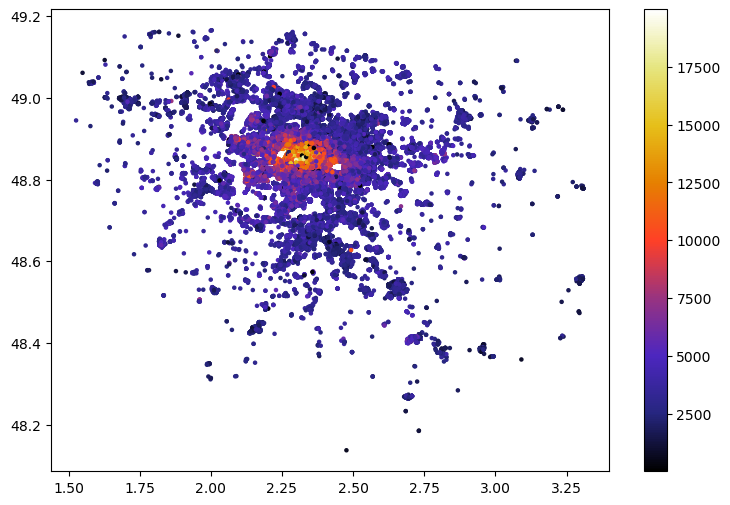

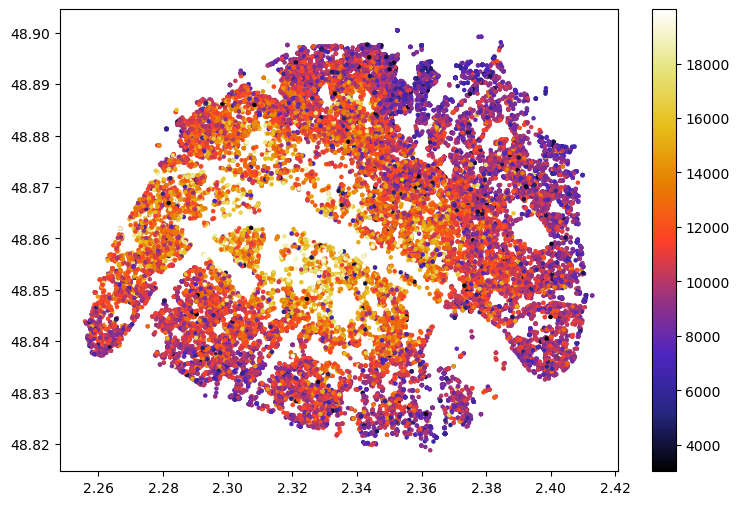

In [5]:
colors_idf = np.array(df_idf['prix_m2'])
colors_paris = np.array(df_paris['prix_m2'])

plt.figure(figsize=(9,6))
plt.scatter(df_idf['longitude'],df_idf['latitude'], c=colors_idf, cmap='CMRmap', s=5)
plt.colorbar()
plt.show()

plt.figure(figsize=(9,6))
plt.scatter(df_paris['longitude'],df_paris['latitude'], c=colors_paris, cmap='CMRmap', s=5)
plt.colorbar()
plt.show()

J'enregistre mes deux dataframes au format .pkl pour les utiliser plus tard dans le choix d'un model prédictif de prix au m².

In [6]:
'''with open(r"dataFrames\df_idf.pkl", "wb") as f:
    my_pickler = pickle.Pickler(f)
    my_pickler.dump(df_idf)'''

'''with open(r"dataFrames\df_paris.pkl", "wb") as f:
    my_pickler = pickle.Pickler(f)
    my_pickler.dump(df_paris)
'''

df_idf.to_csv(r"dataFrames\df_idf.csv", header=True)
df_paris.to_csv(r"dataFrames\df_paris.csv", header=True)